# 1. DL Model (target basin only)

## Basic Settings

### 0. Import libraries

In [ ]:
import os
import sys
import json
import platform
import warnings
import re
import copy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.gridliner as gridliner
import seaborn as sns
import rasterio
from rasterio.mask import mask
from rasterio.transform import rowcol
from tqdm.auto import tqdm
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import optuna

# Set base directory
if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/lsj'
    cpuserver_data_FP = base_FP + '/cpuserver_data'
    nas_data_FP = '/Volumes/qnap_nas'
elif platform.system() == 'Linux':  # Linux systems (Workstation / CPU Server GPU Server)
    base_FP = '/home/seongjun'
    cpuserver_data_FP = base_FP + '/cpuserver_data' # Workstation / GPU Server
    if not os.path.exists(cpuserver_data_FP):
        cpuserver_data_FP = '/data' # CPU Server
    nas_data_FP = base_FP + '/NAS'

# Private modules
sys.path.append(os.path.join(base_FP, 'python_modules'))
import Slack.slack_notifier as Slack # type: ignore
env_path = os.path.join(base_FP, '.env')
notipy = Slack.Notifier(env_path)

# Suppress specific warnings
warnings.filterwarnings('ignore', category=pd.err 1ors.DtypeWarning)

In [2]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


### Function

In [3]:
class FCNNModel(nn.Module):
    def __init__(self, device, input_size, activation_name='ReLU',n_layers=3, hidden_size=[128, 64, 32], dropout_rate=0):
        """
        Fully Connected Neural Network Model
        - Decreasing Hidden Size
        """
        super(FCNNModel, self).__init__()

        # Activation function
        self.activation_name = activation_name
        self.activation_functions = {
            'ReLU': nn.ReLU(),
            'LeakyReLU': nn.LeakyReLU(),
            'Sigmoid': nn.Sigmoid(),
            'Tanh': nn.Tanh(),
            'Softplus': nn.Softplus()
        }

        self.activation = self.activation_functions.get(self.activation_name, nn.ReLU())  # Default to ReLU

        # Fully Connected Layers
        self.input_size = input_size
        layers = []
        in_features = self.input_size

        for i in range(n_layers):
            layers.append(nn.Linear(in_features=in_features, out_features=hidden_size[i]))
            layers.append(nn.BatchNorm1d(hidden_size[i]))  # BatchNorm
            layers.append(self.activation)  # Activation
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate)) # Dropout
            in_features = hidden_size[i]  # Update the input size for the next layer

        # Output layer
        layers.append(nn.Linear(in_features, 1))

        # Final model
        self.model = nn.Sequential(*layers)  # Use nn.Sequential for concise representation
        self.model.to(device)

    def forward(self, x):
        """
        Forward Pass
        """
        return self.model(x)

In [4]:
class EarlyStopping:
    def __init__(self, patience, min_delta, gap_threshold, warmup_epochs, verbose=True):
        """
        patience: Number of epochs to wait before stopping if no improvement is seen
        min_delta: Minimum improvement required to be considered as an improvement
        gap_threshold: Maximum allowed difference between Train Loss and Test Loss
        warmup_epochs: Number of initial epochs where gap_threshold is ignored
        verbose: Whether to print the progress
        """
        self.patience = patience
        self.min_delta = min_delta
        self.gap_threshold = gap_threshold
        self.warmup_epochs = warmup_epochs  # Ignore gap in the early epochs
        self.verbose = verbose
        self.stop_reason = None

        self.best_loss = float("inf")
        self.counter = 0
        self.current_epoch = 0  # Track current epoch


    def __call__(self, train_loss, test_loss):
        self.current_epoch += 1  # Epoch count

        if test_loss < self.best_loss - self.min_delta:  # If Test Loss improves
            self.best_loss = test_loss
            self.counter = 0
        else:
            self.counter += 1  # If no improvement, increase the counter

        # Flag for early stopping
        early_stop = False

        # Not apply gap_threshold in the early epochs
        if self.current_epoch > self.warmup_epochs:
            gap = test_loss - train_loss  # Calculate the difference between Train Loss and Test Loss
            if gap > self.gap_threshold:
                self.stop_reason = f"Overfitting gap ({gap:.4f}) exceeded threshold ({self.gap_threshold})"
                early_stop = True

        # Apply patience for early stopping
        if self.counter >= self.patience:
            if not early_stop:
                self.stop_reason = f"No improvement for {self.patience} epochs"
            early_stop = True

        if early_stop and self.verbose:
            print(f"Early stopping at epoch {self.current_epoch}: {self.stop_reason}")

        return early_stop

In [ ]:
def objective(trial, n_epochs, input_size, train_loader, X_test_tensor, y_test_tensor, device):
    """
    Hyperparameter optimization objective function using Optuna framework
    """
    # Number of layers
    n_layers = trial.suggest_int("n_layers", 2, 5)

    # Hidden sizes
    hidden_sizes_config =[]
    first_hidden_size = trial.suggest_int("hidden_size_1", 64, 256)
    hidden_sizes_config.append(first_hidden_size)
    for i in range(1, n_layers):
        current_size = trial.suggest_int(f"hidden_size_{i+1}", max(16, hidden_sizes_config[-1] // 2), hidden_sizes_config[-1])
        hidden_sizes_config.append(current_size)

    # Learning rate
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    # Dropout rate
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)

    # Optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'RMSprop', 'Adam', 'AdamW', 'Adagrad'])

    # Activation function
    activation_name= trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh', 'Softplus'])

    # Weight decay
    weight_decay = trial.suggest_float('weight_decay', 1e-8, 1e-5, log=True)

    # Loss function
    loss_function_name = trial.suggest_categorical("loss_function", ["MSE", "MAE", "Huber"])

    # Initialize model
    model = FCNNModel(
        device=device,
        input_size=input_size,
        n_layers=n_layers,
        hidden_size=hidden_sizes_config,
        dropout_rate=dropout_rate,
        activation_name=activation_name
    )
    model.to(device)
    model = nn.DataParallel(model)

    # Loss Function
    if loss_function_name == "MSE":
        criterion = nn.MSELoss()
    elif loss_function_name == "MAE":
        criterion = nn.L1Loss()
    elif loss_function_name == "Huber":
        criterion = nn.SmoothL1Loss()

    # Optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning Rate Scheduler
    scheduler_name = trial.suggest_categorical("scheduler", ["ReduceLROnPlateau", "CosineAnnealing", "StepLR"])

    if scheduler_name == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=20)
    elif scheduler_name == "CosineAnnealing":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)
    elif scheduler_name == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Early stopping
    early_stopping = EarlyStopping(patience=10, min_delta=0, gap_threshold=0.1, warmup_epochs=10, verbose=False)

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            train_batch_loss = criterion(outputs, batch_y)

            train_batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            total_train_loss += train_batch_loss.item()

        train_loss = (total_train_loss / len(train_loader))

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            test_predictions_tensor = model(X_test_tensor)
            test_loss = criterion(test_predictions_tensor, y_test_tensor)

        # Learning Rate Scheduler
        if scheduler_name == "ReduceLROnPlateau":
            scheduler.step(test_loss.item())
        else:
            scheduler.step()

        # Early stopping check
        if early_stopping(train_loss, test_loss.item()):
            break

        # Report loss to Optuna for pruning
        trial.report(test_loss.item(), epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    torch.cuda.empty_cache()
    return test_loss.item()

In [6]:
class ModelTrainer:
    """
    Model Trainer class
    """
    def __init__(self, n_epochs, target_basin, input_size, activation_name, n_layers, hidden_size, dropout_rate,
                 weight_decay, loss_function_name, optimizer_name, scheduler_name, learning_rate, device, output_dir):
        self.n_epochs = n_epochs
        self.device = device
        self.target_basin = target_basin
        self.output_dir = output_dir
        self.save_dir = os.path.join(self.output_dir, 'loss_curves')
        os.makedirs(self.save_dir, exist_ok=True) # Create loss_curves directory

        # Model initialization
        self.model = FCNNModel(device=device, input_size=input_size, activation_name=activation_name, n_layers=n_layers, hidden_size=hidden_size, dropout_rate=dropout_rate)

        # Loss function initialization
        self.criterion = self._get_loss_function(loss_function_name)

        # Optimizer initialization
        self.optimizer = self._get_optimizer(optimizer_name, learning_rate, weight_decay)

        # Scheduler initialization
        self.scheduler = self._get_scheduler(scheduler_name, n_epochs)

        # Early stopping initialization
        self.early_stopping = EarlyStopping(patience=10, min_delta=0, gap_threshold=0.1, warmup_epochs=20, verbose=True)

    def _get_loss_function(self, name):
        loss_functions = {
            "MSE": nn.MSELoss(),
            "MAE": nn.L1Loss(),
            "Huber": nn.SmoothL1Loss()
        }
        return loss_functions.get(name, nn.MSELoss())

    def _get_optimizer(self, name, lr, weight_decay):
        optimizers = {
            "SGD": optim.SGD,
            "RMSprop": optim.RMSprop,
            "Adam": optim.Adam,
            "AdamW": optim.AdamW,
            "Adagrad": optim.Adagrad,
        }
        optimizer_class = optimizers.get(name, optim.Adam)
        return optimizer_class(self.model.parameters(), lr=lr, weight_decay=weight_decay)


    def _get_scheduler(self, name, n_epochs):
        schedulers = {
            "ReduceLROnPlateau": torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=20),
            "CosineAnnealing": torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=n_epochs, eta_min=1e-6),
            "StepLR": torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.5),
        }
        return schedulers.get(name, None)

    def train(self, train_loader, X_test_tensor, y_test_tensor, n_epochs):
        train_losses = []
        test_losses = []

        for epoch in range(n_epochs):
            self.model.train()
            total_train_loss = 0.0

            for batch_X, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)

                train_batch_loss = self.criterion(outputs, batch_y)
                train_batch_loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.optimizer.step()
                total_train_loss += train_batch_loss.item()

            train_loss = total_train_loss / len(train_loader)
            train_losses.append(train_loss)

            # Evaluate the model
            self.model.eval()
            with torch.no_grad():
                test_predictions_tensor = self.model(X_test_tensor)
                test_loss = self.criterion(test_predictions_tensor, y_test_tensor)
                test_losses.append(test_loss.item())

            # Learning Rate Scheduler
            if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(test_loss.item())
            elif self.scheduler is not None:
                self.scheduler.step()

            # Early stopping check
            if self.early_stopping(train_loss, test_loss.item()):
                print(f"Early stopping at epoch {epoch+1}")
                break

        self._save_loss_plot(train_losses, test_losses)
        return self.model

    def _save_loss_plot(self, train_losses, test_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(train_losses)), train_losses, label='Train Loss', linewidth=2)
        plt.plot(range(len(test_losses)), test_losses, label='Test Loss', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss Curves')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, f'{self.target_basin}_loss_curves.png'), dpi=300)
        plt.clf()
        plt.close()

In [7]:
def find_neighboring_basins(target_mbsncd_code, gdf):
    """
    Finds MBSNCDs whose geometries touch the geometry of the target MBSNCD.

    Args:
        target_mbsncd_code (str or int): The MBSNCD code to find neighbors for.
                                         Ensure its type matches the type of values in gdf['MBSNCD'].
        gdf (gpd.GeoDataFrame): The GeoDataFrame containing 'MBSNCD' and 'geometry' columns.

    Returns:
        list: A list of neighboring MBSNCD codes. Returns an empty list if the target_mbsncd_code
              is not found or has no direct neighbors.
    """
    # Retrieve the target geometry
    target_row = gdf[gdf['MBSNCD'] == target_mbsncd_code]
    if target_row.empty:
        print(f"MBSNCD code {target_mbsncd_code} not found in the GeoDataFrame.")
        return []

    target_geometry = target_row['geometry'].iloc[0]

    if target_geometry is None:
        print(f"Geometry for MBSNCD code {target_mbsncd_code} is missing.")
        return []

    neighbors = []
    # Iterate through all geometries to find touching ones
    for index, row in gdf.iterrows():
        # Skip if it's the same MBSNCD or if geometry is missing
        if row['MBSNCD'] == target_mbsncd_code or row['geometry'] is None:
            continue

        # Check if geometries touch (share a boundary)
        if target_geometry.touches(row['geometry']):
            neighbors.append(row['MBSNCD'])

    return neighbors

In [ ]:
def plot_evaluation_results(y_train_original, train_predictions_original, y_test_original, test_predictions_original,   model_name, save_dir):
    """
    Function for calculating evaluation metrics and visualizing 1:1 results
    """
    # 1. Calculate evaluation metrics
    training_rmse = np.sqrt(mean_squared_error(y_train_original, train_predictions_original))
    validation_rmse = np.sqrt(mean_squared_error(y_test_original, test_predictions_original))
    training_r2 = r2_score(y_train_original, train_predictions_original)
    validation_r2 = r2_score(y_test_original, test_predictions_original)
    training_mae = mean_absolute_error(y_train_original, train_predictions_original)
    validation_mae = mean_absolute_error(y_test_original, test_predictions_original)
    training_mape = mean_absolute_percentage_error(y_train_original, train_predictions_original)
    validation_mape = mean_absolute_percentage_error(y_test_original, test_predictions_original)

    # 2. Visualization
    global_min = min(y_train_original.min(), train_predictions_original.min(), y_test_original.min(), test_predictions_original.min())
    global_max = max(y_train_original.max(), train_predictions_original.max(), y_test_original.max(), test_predictions_original.max())
    font_size = 20

    plt.figure(figsize=(18, 9))

    # Training Data Plot
    plt.subplot(1, 2, 1)
    sns.kdeplot(x=y_train_original, y=train_predictions_original, cmap="Blues", fill=True, bw_adjust=1)
    plt.scatter(y_train_original, train_predictions_original, color='blue', edgecolor='k', alpha=0.6, label='Training Data')
    plt.plot([global_min, global_max], [global_min, global_max], color='red', linestyle='--', linewidth=2)
    plt.xlabel('Observed Chlorophyll-a (mg/m^3)', fontsize=font_size)
    plt.ylabel('Predicted Chlorophyll-a (mg/m^3)', fontsize=font_size)
    plt.title(f'{model_name} - Training Data\n'
              f'RMSE: {training_rmse:.4f} | MAE: {training_mae:.4f}\n'
              f'R²: {training_r2:.4f} | MAPE: {training_mape:.4f}',
              fontsize=font_size)
    plt.xlim(global_min, global_max)
    plt.ylim(global_min, global_max)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(fontsize=font_size - 2)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=font_size - 4)

    # Validation Data Plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(x=y_test_original, y=test_predictions_original, cmap="Greens", fill=True, bw_adjust=1)
    plt.scatter(y_test_original, test_predictions_original, color='green', edgecolor='k', alpha=0.6, label='Validation Data')
    plt.plot([global_min, global_max], [global_min, global_max], color='red', linestyle='--', linewidth=2)
    plt.xlabel('Observed Chlorophyll-a (mg/m³)', fontsize=font_size)
    plt.ylabel('Predicted Chlorophyll-a (mg/m³)', fontsize=font_size)
    plt.title(f'{model_name} - Validation Data\n'
              f'RMSE: {validation_rmse:.4f} | MAE: {validation_mae:.4f}\n'
              f'R²: {validation_r2:.4f} | MAPE: {validation_mape:.4f}',
              fontsize=font_size)
    plt.xlim(global_min, global_max)
    plt.ylim(global_min, global_max)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(fontsize=font_size - 2)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=font_size - 4)

    plt.tight_layout(pad=3.0)

    # 3. Save the plot
    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, f'{model_name}_scatter_plot.png')
    plt.savefig(plot_path, dpi=300)
    plt.show()

### 1. Define Data

In [9]:
# Define predictors (x)
band_list = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
hls_var = band_list + ['blue_std', 'green_std', 'red_std', 'nir_std', 'swir1_std', 'swir2_std', # Band Std
    'NDWI', 'MNDWI', 'NDVI', 'Green_Blue_Ratio', 'NIR_Red_Ratio', # Spectral Indices
    'sensor'] # Sensor

era5_var = ['d2m', 't2m', 'stl1', 'lblt', 'licd', 'lmld', 'lmlt', # ERA5 Land
    'lshf', 'ltlt', 'sf', 'smlt', 'tsn', 'src', 'fal', 'slhf', 'ssr', # ERA5 Land
    'str', 'sshf', 'evabs', 'evaow', 'evatc', 'evavt', 'pev', 'ro', 'es', # ERA5 Land
    'ssro', 'sro', 'e', 'u10', 'v10', 'sp', 'swvl1', 'skt', # ERA5 Land
    'tp', 'tp_24h', 'tp_48h', 'tp_72h']

predictors = hls_var #+ era5_var

# Define target (y)
target = 'itemCloa'

In [10]:
# Find neighboring basins
# Define the target basin code
target_basin = '2001'

# Load .shp file
shp_path = os.path.join(cpuserver_data_FP, 'shape_files/basin/study_basin.shp')
shp_gpd = gpd.read_file(shp_path)
shp_gpd = shp_gpd.sort_values(by='MBSNCD')

# Result
print(f"Finding neighbors for MBSNCD: {target_basin}")
basin_list = find_neighboring_basins(target_basin, shp_gpd)

if basin_list:
    print(f"Neighboring MBSNCDs for {target_basin}: {basin_list}")
else:
    if not shp_gpd[shp_gpd['MBSNCD'] == target_basin].empty:
        print(f"No direct neighbors found for MBSNCD {target_basin}.")

Finding neighbors for MBSNCD: 2001
Neighboring MBSNCDs for 2001: ['1001', '1003', '1303', '2002', '2003', '2004', '2401']


In [11]:
# Define the data type
data_type = ['B', 'D'] # A: River, B: Lake, D: Reservoir

### 2. Load Data

In [12]:
# Define paths
input_dir = os.path.join(nas_data_FP, 'water_quality/HLS_ERA5_Land_test/S30_L30_combined_data.csv')

# Load the data
df = pd.read_csv(input_dir, low_memory=False)
df

,ptNo,ptNm,obs_lat,obs_lon,obs_date,hls_date,sensor,itemTemp,itemCloa,itemTn,...,pev,ro,es,ssro,sro,e,u10,v10,sp,tp
0,1001A10,송천4,37.491389,128.717778,8/8/24,8/9/24,S30,24.7,21.1,1.976,...,-0.001272,0.000097,0.000000e+00,0.000096,1.525506e-06,-0.000868,-1.182999,-0.500963,92853.310,0.000159
1,1001A15,골지천2,37.320000,128.977778,12/1/15,11/30/15,S30,4.0,1.6,2.402,...,-0.000418,0.000024,-3.230000e-05,0.000014,9.406358e-06,-0.000147,4.129852,-0.076385,93643.940,0.000007
2,1001A15,골지천2,37.320000,128.977778,2/13/24,2/13/24,S30,7.5,1.7,1.280,...,-0.000409,0.000090,-8.820000e-06,0.000071,1.947209e-05,-0.000009,4.150497,2.606583,94308.375,0.000000
3,1001A30,조양강,37.439167,128.652778,2/16/16,2/15/16,S30,0.2,5.7,4.205,...,-0.000617,0.000017,-2.160000e-05,0.000017,0.000000e+00,-0.000022,4.085922,-0.092259,94169.190,0.000000
4,1001A30,조양강,37.439167,128.652778,10/11/17,10/10/17,S30,18.8,6.5,2.622,...,-0.000963,0.000041,1.455191e-11,0.000041,1.266599e-07,-0.000495,0.920624,-0.808990,94969.250,0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23333,5303D70,수락저수지,34.846111,126.265000,7/30/21,7/31/21,S30,27.2,45.0,0.419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23334,5303D70,수락저수지,34.846111,126.265000,4/7/22,4/7/22,S30,11.1,10.5,0.524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23335,5303D70,수락저수지,34.846111,126.265000,8/4/23,8/5/23,S30,23.0,8.6,0.902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23336,5303D70,수락저수지,34.846111,126.265000,9/8/23,9/9/23,S30,24.4,14.9,0.409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-processing the datasets

### 1. Filter Data

In [18]:
# 1.1 Copy the original DataFrame
data = df.copy()

# 1.2 Filter data
data = data[data['ptNo'].str[:4] == target_basin] # Single basin code
data = data[data['ptNo'].str[4].isin(data_type)]
data.replace('--', np.nan)                                                               # Define "No Data" to Nan
data[target] = data[target].astype(float)                                              # Convert to float
data[target] = data[target].replace(0, np.nan)
data = data.dropna(subset=[target])
data = data[data[target] > 0]                                                           # Remove 0 values
data = data.sort_values(by=['ptNo', 'obs_date'])
original_data = data.reset_index(drop=True)
original_data

,ptNo,ptNm,obs_lat,obs_lon,obs_date,hls_date,sensor,itemTemp,itemCloa,itemTn,...,pev,ro,es,ssro,sro,e,u10,v10,sp,tp
0,2001B10,안동댐3,36.5925,128.873611,1/10/22,1/9/22,S30,7.2,2.2,1.199,...,-0.000146,0.000047,-2.930000e-07,0.000047,2.756715e-07,-0.000035,1.681610,-0.543787,99189.750,0.000000
1,2001B10,안동댐3,36.5925,128.873611,1/15/19,1/15/19,S30,6.5,1.0,1.362,...,-0.000438,0.000036,-5.880000e-07,0.000036,1.117587e-08,-0.000065,4.042587,-0.463058,98945.125,0.000000
2,2001B10,안동댐3,36.5925,128.873611,1/2/24,1/3/24,L30,8.6,1.3,1.383,...,-0.000195,0.000058,-5.270000e-06,0.000058,5.029142e-07,-0.000090,3.065735,-1.136946,98725.310,0.000064
3,2001B10,안동댐3,36.5925,128.873611,1/3/23,1/4/23,S30,6.2,1.2,1.489,...,-0.000280,0.000018,-8.730000e-06,0.000018,0.000000e+00,-0.000026,3.297833,-1.041077,99879.190,0.000000
4,2001B10,안동댐3,36.5925,128.873611,1/4/18,1/3/18,L30,6.0,2.5,1.703,...,-0.000402,0.000015,-8.070000e-07,0.000015,0.000000e+00,-0.000035,2.520691,-0.521301,99684.940,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2001D10,동면저수지,36.8050,129.028056,5/20/21,5/19/21,S30,18.0,11.6,1.280,...,-0.001522,0.000027,0.000000e+00,0.000027,0.000000e+00,-0.000921,1.195068,-0.429504,95967.375,0.000000
147,2001D10,동면저수지,36.8050,129.028056,6/10/19,6/9/19,S30,14.9,7.1,1.059,...,-0.001344,0.000022,0.000000e+00,0.000022,0.000000e+00,-0.000817,-1.810867,0.149063,95315.750,0.000000
148,2001D10,동면저수지,36.8050,129.028056,6/8/18,6/9/18,S30,11.4,12.7,1.315,...,-0.001154,0.000083,0.000000e+00,0.000083,2.980232e-08,-0.000488,-4.000427,-2.041657,95579.125,0.000005
149,2001D10,동면저수지,36.8050,129.028056,9/1/20,9/1/20,S30,18.2,7.5,0.980,...,-0.001198,0.000226,1.455191e-11,0.000226,0.000000e+00,-0.000707,-1.303848,1.044539,96005.060,0.000000


In [38]:
train_data, test_data = train_test_split(original_data, test_size=0.2, random_state=42)
print(f"Train and test data shape: {train_data.shape}, {test_data.shape}")

Train and test data shape: (120, 66), (31, 66)


### Train Data

In [39]:
# Log transformation
train_data[target] = np.log1p(train_data[target])

# Calculate IQR for outlier removal (based on original training data)
Q1 = train_data[target].quantile(0.25)
Q3 = train_data[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Prepare features and target for training data
X_train_original = train_data[predictors].copy() # Original X (to avoid modification)
y_train_original = train_data[target].copy()   # Original Y (to avoid modification)

# Encode the 'sensor' column (text to number)
X_train_encoded = pd.get_dummies(X_train_original, columns=['sensor'], prefix='sensor')

# Combine the encoded features and target
combined = pd.concat([X_train_encoded, y_train_original], axis=1)

# Convert all columns to numeric (including the encoded 'sensor' column)
# errors='coerce' to convert non-numeric values to NaN
for col in combined.columns:
    combined[col] = pd.to_numeric(combined[col], errors='coerce')

# Remove rows with NaN values
combined = combined.dropna()

# Remove rows with Inf/-Inf values
combined = combined[np.isfinite(combined).all(axis=1)]

# Remove outliers using the boundaries calculated from the training data
combined_cleaned = combined[(combined[target] >= lower_bound) & (combined[target] <= upper_bound)]

# Final training dataset
X_train_final = combined_cleaned.drop(columns=[target])
y_train_final = combined_cleaned[target]

print(X_train_final.columns)

Index(['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'blue_std',
       'green_std', 'red_std', 'nir_std', 'swir1_std', 'swir2_std', 'NDWI',
       'MNDWI', 'NDVI', 'Green_Blue_Ratio', 'NIR_Red_Ratio', 'sensor_L30',
       'sensor_S30'],
      dtype='object')


### Test Data

In [41]:
# --- Pre-processing for test data (test_data) ---
# Log transformation (same as training data)
test_data[target] = np.log1p(test_data[target])

# Test data is not augmented
X_test_origin = test_data[predictors]
y_test_origin = test_data[target]

# 1. One-Hot Encode the 'sensor' column (same as training data)
# Convert the 'sensor' column to numeric format so the model can understand it
X_test_encoded = pd.get_dummies(X_test_origin, columns=['sensor'], prefix='sensor')

# 2. Ensure test set has the same columns as the training set
# To avoid cases where categories only in the training data are missing in the test data,
# force the column order and structure to match the training data
# X_train_final is the final training X data created previously
X_test_final_reindexed = X_test_encoded.reindex(columns=X_train_final.columns, fill_value=0)

# 3. Combine, clean (Remove NaN, inf)
combined_test = pd.concat([X_test_final_reindexed, y_test_origin], axis=1)
combined_test = combined_test.dropna() # to_numeric은 이제 불필요
combined_test = combined_test[np.isfinite(combined_test).all(axis=1)]

# 4. Remove outliers using the boundaries calculated from the training data
# The boundaries (lower_bound, upper_bound) must be calculated from the training data
combined_test_cleaned = combined_test[(combined_test[target] >= lower_bound) & (combined_test[target] <= upper_bound)]

# 5. Final test dataset
X_test_final = combined_test_cleaned.drop(columns=[target])
y_test_final = combined_test_cleaned[target]

print("Final test dataset shape:", X_test_final.shape, y_test_final.shape)

Final test dataset shape: (30, 19) (30,)


## Data Scaling & Data Loader

## Final Datasets

In [49]:
# Data scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_final)
y_train_scaled = scaler_y.fit_transform(y_train_final.values.reshape(-1, 1)).flatten()

X_test_scaled = scaler_X.transform(X_test_final)
y_test_scaled = scaler_y.transform(y_test_final.values.reshape(-1, 1)).flatten()

# Data Loader
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled.reshape(-1, 1), dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled.reshape(-1, 1), dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 32 if len(train_dataset) >= 32 else len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([114, 19])
torch.Size([114, 1])
torch.Size([30, 19])
torch.Size([30, 1])


## Hyperparameter Optimization

In [50]:
# Hyperparameter Optimization
try:
    # Define input_size based on the number of features in X
    input_size = len(X_train_final.columns)
    n_trials = 300
    n_epochs = 100

    # Use Optuna to run the optimization
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Suppress warnings
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=20, interval_steps=5)
    study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(lambda trial: objective(trial, n_epochs, input_size, train_loader, X_test_tensor, y_test_tensor, device),
                   n_trials=n_trials,
                   show_progress_bar=True # Show progress bar
                   )

    # Best parameters
    best_params = study.best_trial.params
    n_layers = best_params['n_layers']
    hidden_size = [best_params[f'hidden_size_{i+1}'] for i in range(n_layers)]  # Only include the necessary hidden sizes
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['lr']
    optimizer_name = best_params['optimizer']
    activation_name = best_params['activation']
    weight_decay = best_params['weight_decay']
    loss_function_name = best_params['loss_function']
    scheduler_name = best_params['scheduler']

    notipy.send_success()

    # Save the best parameters
    params_dict = {
        'n_layers': n_layers,
        'hidden_size': hidden_size,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'optimizer': optimizer_name,
        'activation': activation_name,
        'weight_decay': weight_decay,
        'loss_function': loss_function_name,
        'scheduler': scheduler_name
    }

    save_dir = os.path.join(nas_data_FP, f'water_quality/models/DL_model/surrounding_basins/best_params')
    os.makedirs(save_dir, exist_ok=True)

    params_save_path = os.path.join(save_dir, f'{target_basin}_best_params.json')
    with open(params_save_path, 'w') as f:
        json.dump(params_dict, f, indent=4)

except Exception as e:
    notipy.send_error(e)
    print(e)

  0%|          | 0/300 [00:00<?, ?it/s]

/home/seongjun/miniconda3/envs/lsj/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning:

Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)



## Model Training / Prediction

In [51]:
# Define paths
save_dir = os.path.join(nas_data_FP, f'water_quality/models/DL_model/combined_test/target_basin/')
os.makedirs(save_dir, exist_ok=True)

# Model Training
trainer = ModelTrainer(
    n_epochs=n_epochs,
    n_layers=n_layers,
    input_size=input_size,
    target_basin=target_basin,
    hidden_size=hidden_size,
    dropout_rate=dropout_rate,
    activation_name=activation_name,
    weight_decay=weight_decay,
    loss_function_name=loss_function_name,
    optimizer_name=optimizer_name,
    scheduler_name=scheduler_name,
    learning_rate=learning_rate,
    device=device,
    output_dir=save_dir
)
train_model = trainer.train(train_loader, X_test_tensor, y_test_tensor, n_epochs=100)

# Make predictions on the training and test data
train_model.eval()
with torch.no_grad():
    # Predictions on the training set
    train_predictions_tensor = train_model(X_train_tensor)

    # Predictions on the test set
    test_predictions_tensor = train_model(X_test_tensor)

# Save the model
save_path = os.path.join(save_dir, f'trained_model/{target_basin}.pth')
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(train_model.state_dict(), save_path)

## Model Evaluation

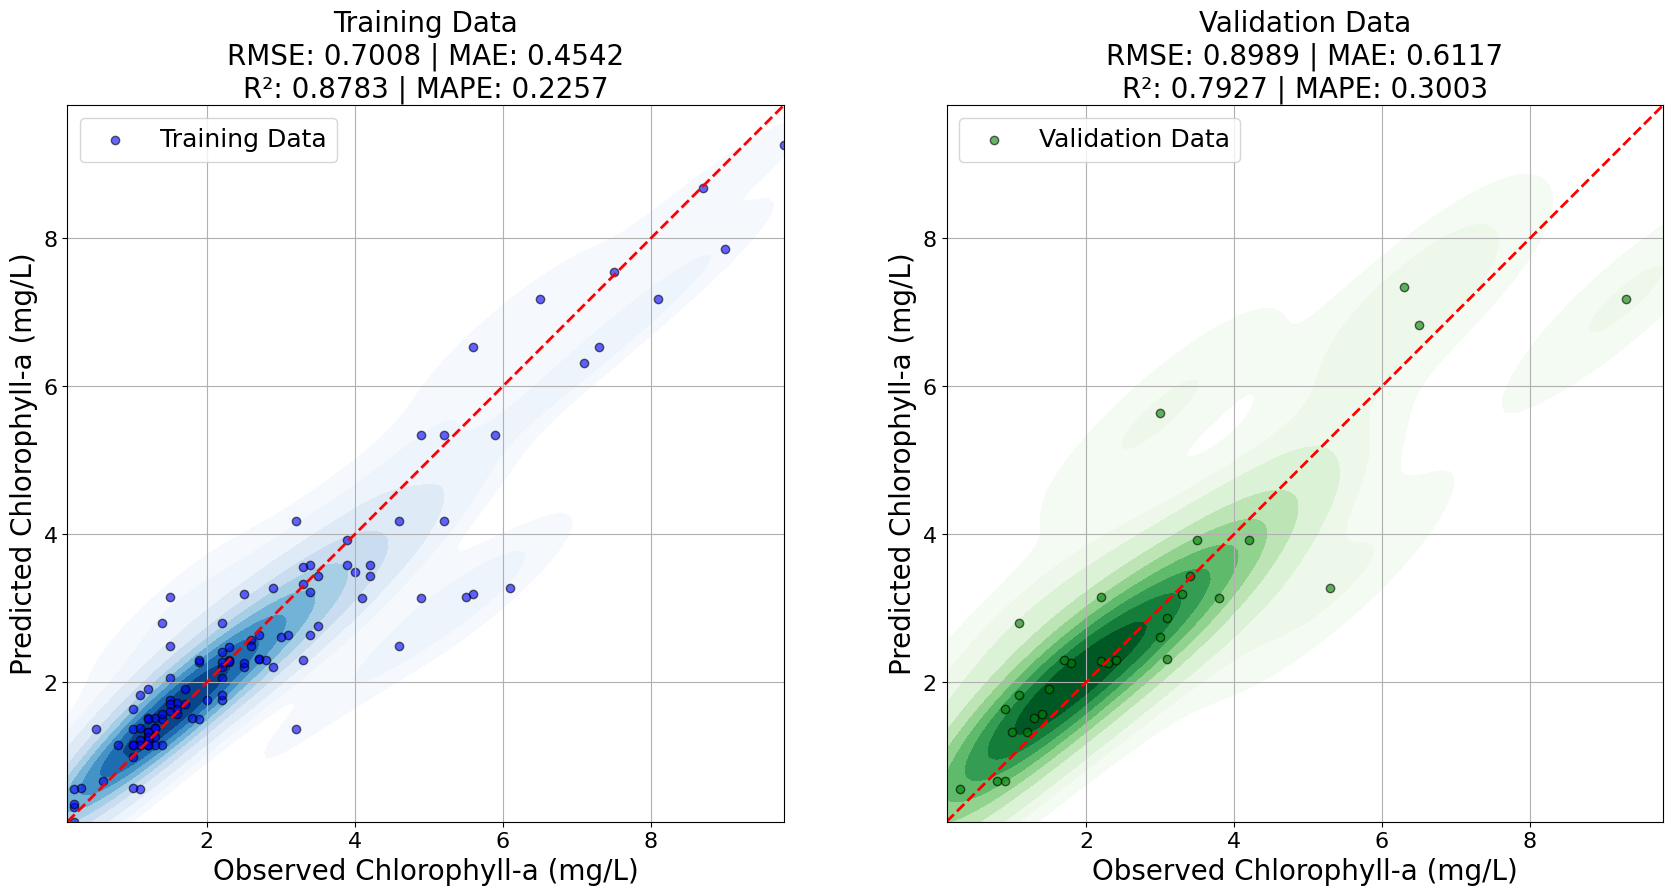

In [ ]:
# Convert predictions and true values to numpy arrays
train_predictions = train_predictions_tensor.cpu().numpy().flatten()
test_predictions = test_predictions_tensor.cpu().numpy().flatten()
y_train = y_train_tensor.cpu().numpy().flatten()
y_test = y_test_tensor.cpu().numpy().flatten()

# Convert predictions and true values to numpy arrays
train_predictions_log = scaler_y.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
test_predictions_log = scaler_y.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_train_log = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_log = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Convert back to original scale
train_predictions_original = np.expm1(train_predictions_log)
test_predictions_original = np.expm1(test_predictions_log)
y_train_original = np.expm1(y_train_log)
y_test_original = np.expm1(y_test_log)

# Determine the global min and max across both training and test sets for consistency
global_min = min(min(y_train_original), min(train_predictions_original), min(y_test_original), min(test_predictions_original))
global_max = max(max(y_train_original), max(train_predictions_original), max(y_test_original), max(test_predictions_original))

# Calculate RMSE for training and validation data
training_rmse = np.sqrt(mean_squared_error(y_train_original, train_predictions_original))
validation_rmse = np.sqrt(mean_squared_error(y_test_original, test_predictions_original))

# Calculate R2 for training and validation data
training_r2 = r2_score(y_train_original, train_predictions_original)
validation_r2 = r2_score(y_test_original, test_predictions_original)

# Calculate MAE for training and validation data
training_mae = mean_absolute_error(y_train_original, train_predictions_original)
validation_mae = mean_absolute_error(y_test_original, test_predictions_original)

# Calculate MAPE for training and validation data
training_mape = mean_absolute_percentage_error(y_train_original, train_predictions_original)
validation_mape = mean_absolute_percentage_error(y_test_original, test_predictions_original)

#----------------------------------------------------------------------------------------------------------------------#

# Visualization
plt.figure(figsize=(18, 9))
font_size = 20

## Training Data Plot
plt.subplot(1, 2, 1)
sns.kdeplot(x=y_train_original, y=train_predictions_original, cmap="Blues", fill=True, bw_adjust=1)
plt.scatter(y_train_original, train_predictions_original, color='blue', edgecolor='k', alpha=0.6, label='Training Data')
plt.plot([global_min, global_max], [global_min, global_max], color='red', linestyle='--', linewidth=2)
plt.xlabel('Observed Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.ylabel('Predicted Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.title(
    f'Training Data\n'
    f'RMSE: {training_rmse:.4f} | MAE: {training_mae:.4f}\n'
    f'R²: {training_r2:.4f} | MAPE: {training_mape:.4f}',
    fontsize=font_size
)
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(fontsize=font_size - 2)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=font_size - 4)

## Validation Data Plot
plt.subplot(1, 2, 2)
sns.kdeplot(x=y_test_original, y=test_predictions_original, cmap="Greens", fill=True, bw_adjust=1)
plt.scatter(y_test_original, test_predictions_original, color='green', edgecolor='k', alpha=0.6, label='Validation Data')
plt.plot([global_min, global_max], [global_min, global_max], color='red', linestyle='--', linewidth=2)
plt.xlabel('Observed Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.ylabel('Predicted Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.title(
    f'Validation Data\n'
    f'RMSE: {validation_rmse:.4f} | MAE: {validation_mae:.4f}\n'
    f'R²: {validation_r2:.4f} | MAPE: {validation_mape:.4f}',
    fontsize=font_size
)
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(fontsize=font_size - 2)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=font_size - 4)

plt.tight_layout(pad=3.0)
save_dir = os.path.join(nas_data_FP, f'water_quality/models/DL_image.pngmodel/combined_test/target_basin/scatter_plot')
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, f'{target_basin}_scatter_plot.png'), dpi=300)
plt.show()

In [53]:
# Save the evaluation metrics
evaluation_metrics = {
    'model_name': f'{target_basin}_DL',
    'training_rmse': training_rmse,
    'validation_rmse': validation_rmse,
    'training_r2': training_r2,
    'validation_r2': validation_r2,
    'training_mae': training_mae,
    'validation_mae': validation_mae,
    'training_mape': training_mape,
    'validation_mape': validation_mape
}

df_evaluation_metrics = pd.DataFrame([evaluation_metrics])

save_dir = os.path.join(nas_data_FP, f'water_quality/models/DL_model/combined_test/target_basin/evaluation_metrics')
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f'{target_basin}_eval_metrics.csv')
df_evaluation_metrics.to_csv(save_path, index=False)

# 2. DL Model (Only surrounding basins)

## Pre-processing the datasets

### 1. Filter Data

In [63]:
# 1.1 Copy the original DataFrame
data = df.copy()

# 1.2 Filter data
data = data[data['ptNo'].str[:4].isin(basin_list)] # Multiple basin code
# data = data[data['ptNo'] != '1001B10']
data = data[data['ptNo'].str[4].isin(data_type)]
data.replace('--', np.nan)                                                               # Define "No Data" to Nan
data[target] = data[target].astype(float)                                              #
data[target] = data[target].replace(0, np.nan)
data = data.dropna(subset=[target])
data = data[data[target] > 0]                                                           # Remove 0 values
data = data.sort_values(by=['ptNo', 'obs_date'])                                         # Sort data based on 'ptNo', 'hls_date'
data = data.reset_index(drop=True)
data

,ptNo,ptNm,obs_lat,obs_lon,obs_date,hls_date,sensor,itemTemp,itemCloa,itemTn,...,pev,ro,es,ssro,sro,e,u10,v10,sp,tp
0,1001B10,광동댐,37.341667,128.949722,1/10/24,1/11/24,L30,2.4,0.2,0.971,...,-0.000330,0.000069,-5.110000e-05,0.000069,7.450581e-09,-0.000076,3.724899,1.203507,92759.750,0.000005
1,1001B10,광동댐,37.341667,128.949722,1/3/17,1/3/17,S30,1.0,1.9,1.454,...,-0.000183,0.000081,-2.400000e-05,0.000069,1.225807e-05,-0.000109,2.113220,0.389877,92861.250,0.000000
2,1001B10,광동댐,37.341667,128.949722,1/3/18,1/3/18,S30,0.0,9.5,2.565,...,-0.000214,0.000040,-3.300000e-05,0.000040,0.000000e+00,-0.000033,1.770691,0.202332,93228.940,0.000000
3,1001B10,광동댐,37.341667,128.949722,1/4/22,1/4/22,S30,1.9,4.9,3.014,...,-0.000444,0.000072,-1.970000e-05,0.000072,0.000000e+00,-0.000020,1.794922,-0.939133,93691.060,0.000000
4,1001B10,광동댐,37.341667,128.949722,1/5/21,1/4/21,S30,-0.5,8.5,1.883,...,-0.000372,0.000043,-6.500000e-06,0.000043,1.676381e-08,-0.000007,2.139053,0.257866,94181.625,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,2401D30,매화저수지,36.882222,129.359167,9/9/24,9/10/24,S30,15.1,4.5,0.641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
911,2401D40,온정저수지,36.707222,129.325556,10/25/23,10/24/23,L30,16.6,19.7,0.605,...,-0.000699,0.000162,0.000000e+00,0.000162,0.000000e+00,-0.000345,2.564499,0.079799,97895.750,0.000000
912,2401D40,온정저수지,36.707222,129.325556,3/23/18,3/24/18,L30,5.0,2.9,1.128,...,-0.001022,0.000058,-8.120000e-05,0.000019,3.857538e-05,-0.000395,4.406738,-0.385468,97655.560,0.000000
913,2401D40,온정저수지,36.707222,129.325556,8/17/22,8/18/22,L30,25.4,8.9,1.404,...,-0.000872,0.000013,1.455191e-10,0.000007,6.327406e-06,-0.000708,-0.590836,0.312149,96716.690,0.000702


### 2. Data Augmentation / Outlier Removal

In [64]:
train_surr_data, test_surr_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"Train and test data shape: {train_surr_data.shape}, {test_surr_data.shape}")

Train and test data shape: (732, 66), (183, 66)


In [ ]:
# Log transformation
train_surr_data[target] = np.log1p(train_surr_data[target])

# Calculate IQR for outlier removal (based on original training data)
Q1 = train_surr_data[target].quantile(0.25)
Q3 = train_surr_data[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Prepare features and target for training data (NO AUGMENTATION)
X_train_surr_original = train_surr_data[predictors].copy() #
y_train_surr_original = train_surr_data[target].copy()

# One-Hot Encoding
X_train_surr_encoded = pd.get_dummies(X_train_surr_original, columns=['sensor'], prefix='sensor')

# Final training dataset
combined_surr = pd.concat([X_train_surr_encoded, y_train_surr_original], axis=1)

# Convert all columns to numeric
# errors='coerce' to convert non-numeric values to NaN
for col in combined_surr.columns:
    combined_surr[col] = pd.to_numeric(combined_surr[col], errors='coerce')

# Remove rows with NaN values
combined_surr = combined_surr.dropna()

# Remove rows with Inf/-Inf values
combined_surr = combined_surr[np.isfinite(combined_surr).all(axis=1)]

# Remove outliers using the boundaries calculated from the training data
combined_surr_cleaned = combined_surr[(combined_surr[target] >= lower_bound) & (combined_surr[target] <= upper_bound)]

# Final training dataset
X_train_surr_final = combined_surr_cleaned.drop(columns=[target])
y_train_surr_final = combined_surr_cleaned[target]

print(X_train_surr_final.shape)
print(y_train_surr_final.shape)

(705, 19)
(705,)


In [ ]:
# --- Pre-processing for test data (test_data) ---
# Log transformation (Same as training data)
test_surr_data[target] = np.log1p(test_surr_data[target])

# Test data is not augmented
X_test_surr_origin = test_surr_data[predictors]
y_test_surr_origin = test_surr_data[target]

# 1. One-Hot Encode the 'sensor' column (Same as training data)
# Convert 'sensor' column to numeric format for the deep learning model
X_test_surr_encoded = pd.get_dummies(X_test_surr_origin, columns=['sensor'], prefix='sensor')

# 2. Ensure test set has the same columns as the training set
# To avoid the case where categories only in the training data are missing in the test data,
# force the column order and structure of the training data
X_train_final is the final training X data created previously.
X_test_surr_final_reindexed = X_test_surr_encoded.reindex(columns=X_train_surr_final.columns, fill_value=0)

# 3. Combine, clean (Remove NaN, inf)
combined_test_surr = pd.concat([X_test_surr_final_reindexed, y_test_surr_origin], axis=1)
combined_test_surr = combined_test_surr.dropna()
combined_test_surr = combined_test_surr[np.isfinite(combined_test_surr).all(axis=1)]

# 4. Remove outliers using the boundaries calculated from the training data
# The boundaries (lower_bound, upper_bound) must be calculated from the training data
combined_test_surr_cleaned = combined_test_surr[(combined_test_surr[target] >= lower_bound) & (combined_test_surr[target] <= upper_bound)]

# 5. Final test dataset
X_test_surr_final = combined_test_surr_cleaned.drop(columns=[target])
y_test_surr_final = combined_test_surr_cleaned[target]

print("Final test dataset shape:", X_test_surr_final.shape, y_test_surr_final.shape)

Final test dataset shape: (174, 19) (174,)


### 4. Scaling

In [67]:
# Define scaler
scaler_X_surr = StandardScaler()
scaler_y_surr = StandardScaler()

X_train_surr_scaled = scaler_X_surr.fit_transform(X_train_surr_final)
y_train_surr_scaled = scaler_y_surr.fit_transform(y_train_surr_final.values.reshape(-1, 1)).flatten()

X_test_surr_scaled = scaler_X_surr.transform(X_test_surr_final)
y_test_surr_scaled = scaler_y_surr.transform(y_test_surr_final.values.reshape(-1, 1)).flatten()

# Data Loader
X_train_surr_tensor = torch.tensor(X_train_surr_scaled, dtype=torch.float32).to(device)
y_train_surr_tensor = torch.tensor(y_train_surr_scaled.reshape(-1, 1), dtype=torch.float32).to(device)
X_test_surr_tensor = torch.tensor(X_test_surr_scaled, dtype=torch.float32).to(device)
y_test_surr_tensor = torch.tensor(y_test_surr_scaled.reshape(-1, 1), dtype=torch.float32).to(device)

train_surr_dataset = TensorDataset(X_train_surr_tensor, y_train_surr_tensor)
batch_size = 32 if len(train_surr_dataset) >= 32 else len(train_surr_dataset)
train_surr_loader = DataLoader(train_surr_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(X_train_surr_tensor.shape)
print(y_train_surr_tensor.shape)
print(X_test_surr_tensor.shape)
print(y_test_surr_tensor.shape)

torch.Size([705, 19])
torch.Size([705, 1])
torch.Size([174, 19])
torch.Size([174, 1])


## Hyperparameter Optimization

In [68]:
# Hyperparameter Optimization
try:
    # Define input_size based on the number of features in X
    input_size = len(X_train_surr_final.columns)
    n_trials = 300
    n_epochs = 100

    # Use Optuna to run the optimization
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Suppress warnings
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=20, interval_steps=5)
    study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(lambda trial: objective(trial, n_epochs, input_size, train_surr_loader, X_test_surr_tensor, y_test_surr_tensor, device),
                   n_trials=n_trials,
                   show_progress_bar=True # Show progress bar
                   )

    # Best parameters
    best_params = study.best_trial.params
    n_layers = best_params['n_layers']
    hidden_size = [best_params[f'hidden_size_{i+1}'] for i in range(n_layers)]  # Only include the necessary hidden sizes
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['lr']
    optimizer_name = best_params['optimizer']
    activation_name = best_params['activation']
    weight_decay = best_params['weight_decay']
    loss_function_name = best_params['loss_function']
    scheduler_name = best_params['scheduler']

    notipy.send_success()

    # Save the best parameters
    params_dict = {
        'n_layers': n_layers,
        'hidden_size': hidden_size,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'optimizer': optimizer_name,
        'activation': activation_name,
        'weight_decay': weight_decay,
        'loss_function': loss_function_name,
        'scheduler': scheduler_name
    }

    save_dir = os.path.join(nas_data_FP, 'water_quality/models/DL_model/combined_test/surrounding_basins/best_params')
    os.makedirs(save_dir, exist_ok=True)

    params_save_path = os.path.join(save_dir, f'{target_basin}_best_params.json')
    with open(params_save_path, 'w') as f:
        json.dump(params_dict, f, indent=4)

except Exception as e:
    notipy.send_error(e)
    print(e)

  0%|          | 0/300 [00:00<?, ?it/s]

## Model Training / Prediction

In [69]:
# Define paths
save_dir = os.path.join(nas_data_FP, f'water_quality/models/DL_model/combined_test/surrounding_basins')
os.makedirs(save_dir, exist_ok=True)

# Model Training
surr_trainer = ModelTrainer(
    n_epochs=n_epochs,
    n_layers=n_layers,
    input_size=input_size,
    target_basin=target_basin,
    hidden_size=hidden_size,
    dropout_rate=dropout_rate,
    activation_name=activation_name,
    weight_decay=weight_decay,
    loss_function_name=loss_function_name,
    optimizer_name=optimizer_name,
    scheduler_name=scheduler_name,
    learning_rate=learning_rate,
    device=device,
    output_dir=save_dir
)
surr_trained_model = surr_trainer.train(train_surr_loader, X_test_surr_tensor, y_test_surr_tensor, n_epochs=100)

# Make predictions on the training and test data
surr_trained_model.eval()
with torch.no_grad():
    # Predictions on the training set
    surr_train_predictions_tensor = surr_trained_model(X_train_surr_tensor)

    # Predictions on the validation set (Same as the target basin)
    surr_validation_predictions_tensor = surr_trained_model(X_test_tensor)

# Save the model
save_path = os.path.join(save_dir, f'trained_model/{target_basin}.pth')
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(surr_trained_model.state_dict(), save_path)

Early stopping at epoch 44: No improvement for 10 epochs
Early stopping at epoch 44


## Model Validation

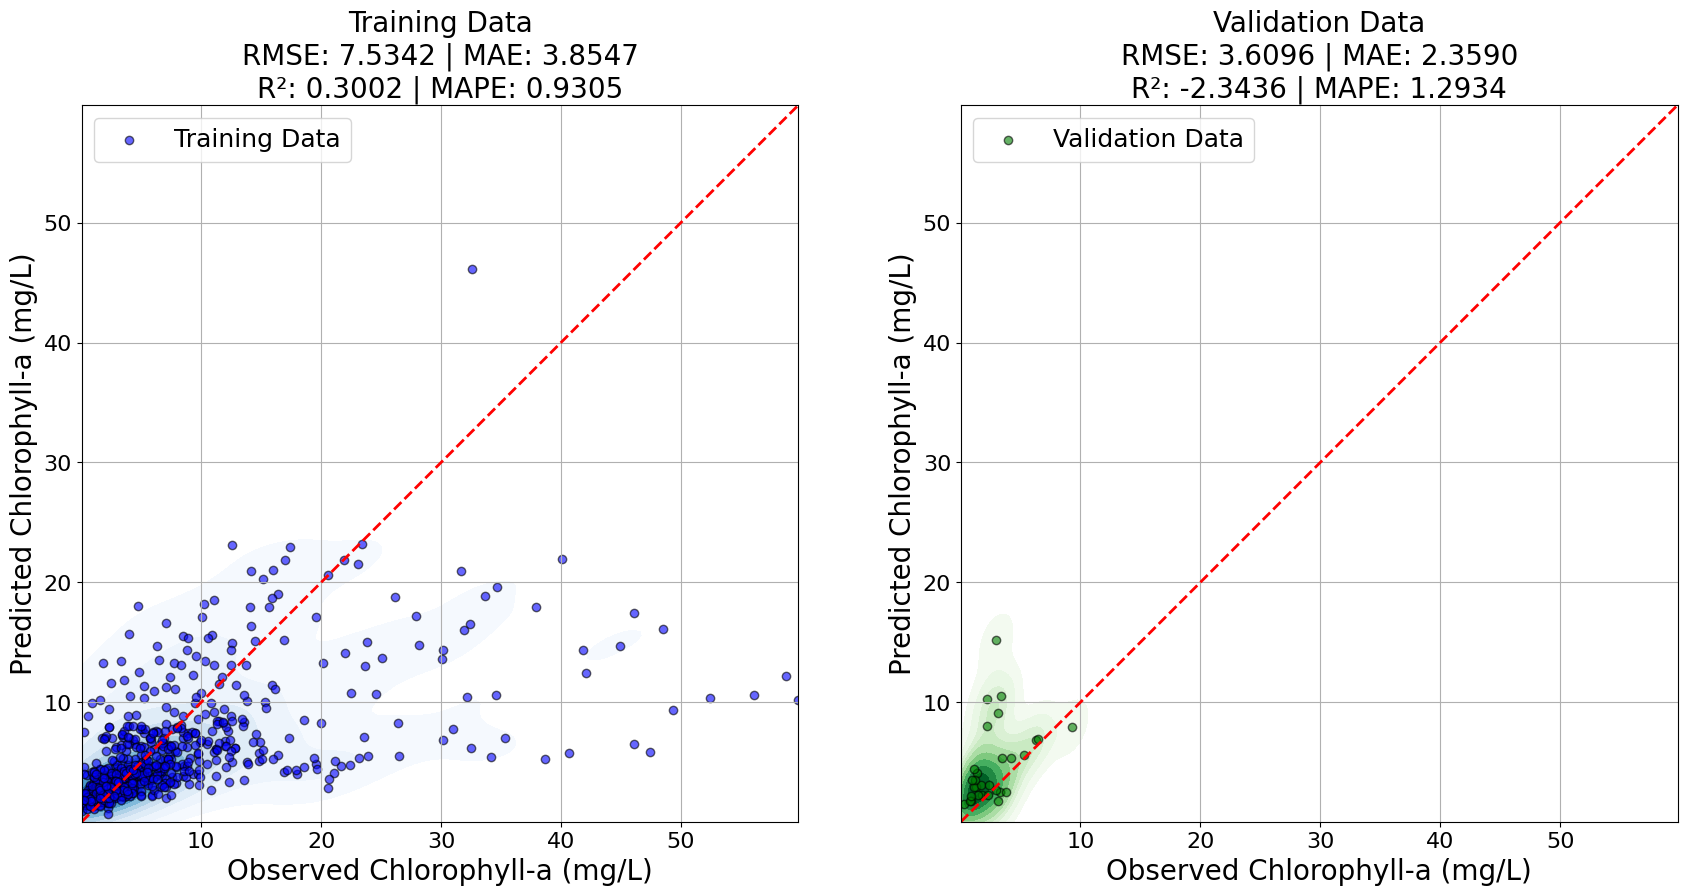

In [ ]:
# Convert predictions and true values to numpy arrays
train_predictions = surr_train_predictions_tensor.cpu().numpy().flatten()
validation_predictions = surr_validation_predictions_tensor.cpu().numpy().flatten()
y_train = y_train_surr_tensor.cpu().numpy().flatten()
y_validation = y_test_tensor.cpu().numpy().flatten()

# Reverse the StandardScaler to return to the log scale.
train_predictions_log = scaler_y_surr.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
validation_predictions_log = scaler_y_surr.inverse_transform(validation_predictions.reshape(-1, 1)).flatten()
y_train_log = scaler_y_surr.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_validation_log = scaler_y.inverse_transform(y_validation.reshape(-1, 1)).flatten()

# Reverse the log scale to the original chl_a values.
train_predictions_original = np.expm1(train_predictions_log)
validation_predictions_original = np.expm1(validation_predictions_log)
y_train_original = np.expm1(y_train_log)
y_validation_original = np.expm1(y_validation_log)

# Determine the global min and max across both training and test sets for consistency
global_min = min(min(y_train_original), min(train_predictions_original), min(y_validation_original), min(validation_predictions_original))
global_max = max(max(y_train_original), max(train_predictions_original), max(y_validation_original), max(validation_predictions_original))

# Calculate RMSE for training and validation data
training_rmse = np.sqrt(mean_squared_error(y_train_original, train_predictions_original))
validation_rmse = np.sqrt(mean_squared_error(y_validation_original, validation_predictions_original))

# Calculate R2 for training and validation data
training_r2 = r2_score(y_train_original, train_predictions_original)
validation_r2 = r2_score(y_validation_original, validation_predictions_original)

# Calculate MAE for training and validation data
training_mae = mean_absolute_error(y_train_original, train_predictions_original)
validation_mae = mean_absolute_error(y_validation_original, validation_predictions_original)

# Calculate MAPE for training and validation data
training_mape = mean_absolute_percentage_error(y_train_original, train_predictions_original)
validation_mape = mean_absolute_percentage_error(y_validation_original, validation_predictions_original)

# Plot
plt.figure(figsize=(18, 9))
font_size = 20

# Training Data Plot
plt.subplot(1, 2, 1)
sns.kdeplot(x=y_train_original, y=train_predictions_original, cmap="Blues", fill=True, bw_adjust=1)
plt.scatter(y_train_original, train_predictions_original, color='blue', edgecolor='k', alpha=0.6, label='Training Data')
plt.plot([global_min, global_max], [global_min, global_max], color='red', linestyle='--', linewidth=2)
plt.xlabel('Observed Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.ylabel('Predicted Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.title(
    f'Training Data\n'
    f'RMSE: {training_rmse:.4f} | MAE: {training_mae:.4f}\n'
    f'R²: {training_r2:.4f} | MAPE: {training_mape:.4f}',
    fontsize=font_size
)
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(fontsize=font_size - 2)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=font_size - 4)

# Validation Data Plot
plt.subplot(1, 2, 2)
sns.kdeplot(x=y_validation_original, y=validation_predictions_original, cmap="Greens", fill=True, bw_adjust=1)
plt.scatter(y_validation_original, validation_predictions_original, color='green', edgecolor='k', alpha=0.6, label='Validation Data')
plt.plot([global_min, global_max], [global_min, global_max], color='red', linestyle='--', linewidth=2)
plt.xlabel('Observed Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.ylabel('Predicted Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.title(
    f'Validation Data\n'
    f'RMSE: {validation_rmse:.4f} | MAE: {validation_mae:.4f}\n'
    f'R²: {validation_r2:.4f} | MAPE: {validation_mape:.4f}',
    fontsize=font_size
)
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(fontsize=font_size - 2)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=font_size - 4)

plt.tight_layout(pad=3.0)
save_dir = os.path.join(nas_data_FP, f'water_quality/models/DL_image.pngmodel/combined_test/surrounding_basins/scatter_plot')
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, f'{target_basin}_scatter_plot.png'), dpi=300)
plt.show()

In [71]:
# Save the evaluation metrics
evaluation_metrics = {
    'model_name': f'combined_test_{target_basin}_surrounding_DL',
    'training_rmse': training_rmse,
    'validation_rmse': validation_rmse,
    'training_r2': training_r2,
    'validation_r2': validation_r2,
    'training_mae': training_mae,
    'validation_mae': validation_mae,
    'training_mape': training_mape,
    'validation_mape': validation_mape
}

df_evaluation_metrics = pd.DataFrame([evaluation_metrics])

save_dir = os.path.join(nas_data_FP, f'water_quality/models/DL_model/combined_test/surrounding_basins/evaluation_metrics')
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f'{target_basin}_eval_metrics.csv')
df_evaluation_metrics.to_csv(save_path, index=False)

# Transfer Learning

## 1. Pre-Trained Model

In [84]:
# Copy the model
pre_trained_model = copy.deepcopy(surr_trained_model)
pre_trained_model

FCNNModel(
  (activation): LeakyReLU(negative_slope=0.01)
  (model): Sequential(
    (0): Linear(in_features=19, out_features=78, bias=True)
    (1): BatchNorm1d(78, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=78, out_features=72, bias=True)
    (4): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=72, out_features=38, bias=True)
    (7): BatchNorm1d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=38, out_features=20, bias=True)
    (10): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=20, out_features=19, bias=True)
    (13): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): 

## 2. Hyperparameter Optimization

In [85]:
# Load the best parameters
with open(params_save_path, 'r') as f:
    best_params = json.load(f)

# Check the loaded parameters
print("Pre-trained model's Best Parameters:")
print(best_params)

Pre-trained model's Best Parameters:
{'n_layers': 5, 'hidden_size': [78, 72, 38, 20, 19], 'dropout_rate': 0.0, 'learning_rate': 0.005656534541781219, 'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'weight_decay': 2.3341234091835602e-08, 'loss_function': 'Huber', 'scheduler': 'ReduceLROnPlateau'}


In [86]:
def finetune_objective(trial, device, pre_trained_model, best_params, train_loader, X_test_tensor, y_test_tensor, n_epochs):
    """
    Optuna objective function for fine-tuning a pre-trained model.
    Use the best_params from the JSON file and tune only the learning rate.
    """
    # --- 1. Tune only the learning rate ---
    lr = trial.suggest_float('lr', 1e-15, 1e-8, log=True)

    # --- 2. Prepare the model and apply the freezing strategy (fixed) ---
    model = copy.deepcopy(pre_trained_model)
    model.to(device)

    # Freeze all layers except the last layer
    for param in model.parameters():
        param.requires_grad = False
    for param in model.model[-1].parameters():
        param.requires_grad = True

    # --- 3. Set the optimizer, loss function, and scheduler based on best_params ---

    # Set the loss function
    loss_function_name = best_params['loss_function']
    if loss_function_name == "MSE":
        criterion = nn.MSELoss()
    elif loss_function_name == "MAE":
        criterion = nn.L1Loss()
    elif loss_function_name == "Huber":
        criterion = nn.SmoothL1Loss()
    else:
        raise ValueError(f"Unknown loss function: {loss_function_name}")

    # Set the optimizer
    optimizer_name = best_params['optimizer']
    weight_decay = best_params['weight_decay']
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Set the scheduler
    scheduler_name = best_params['scheduler']
    if scheduler_name == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10)
    elif scheduler_name == "CosineAnnealing":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)
    elif scheduler_name == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    else:
        # If the scheduler is not used, set it to None
        scheduler = None

    # --- 4. Training and evaluation loop (same as before) ---
    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            train_batch_loss = criterion(outputs, batch_y)
            train_batch_loss.backward()
            optimizer.step()
            total_train_loss += train_batch_loss.item()

        train_loss = total_train_loss / len(train_loader)

        model.eval()
        with torch.no_grad():
            test_predictions_tensor = model(X_test_tensor)
            test_loss = criterion(test_predictions_tensor, y_test_tensor)

        if scheduler:
            if scheduler_name == "ReduceLROnPlateau":
                scheduler.step(test_loss.item())
            else:
                scheduler.step()

        trial.report(test_loss.item(), epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    torch.cuda.empty_cache()
    return test_loss.item()


In [87]:
finetune_study = optuna.create_study(direction='minimize')

finetune_study.optimize(
    lambda trial: finetune_objective(
        trial,
        pre_trained_model=surr_trained_model,
        best_params=best_params, # Load the best parameters
        n_epochs=100,
        train_loader=train_loader,
        X_test_tensor=X_test_tensor,
        y_test_tensor=y_test_tensor,
        device=device
    ),
    n_trials=300,
    show_progress_bar=True
)

# Result
print("Best trial for Fine-tuning:")
best_finetune_trial = finetune_study.best_trial
print(f"  Validation Loss: {best_finetune_trial.value}")
print("  Best Params (Learning Rate): ")
for key, value in best_finetune_trial.params.items():
    print(f"    {key}: {value}")

  0%|          | 0/300 [00:00<?, ?it/s]

Best trial for Fine-tuning:
  Validation Loss: 0.31752869486808777
  Best Params (Learning Rate): 
    lr: 4.350059246863821e-15


Fine-tuning을 위한 최적의 학습률(lr): 0.00000000

최종 모델 훈련 시작...
Epoch [10/100], Loss: 0.468105
Epoch [20/100], Loss: 0.473540
Epoch [30/100], Loss: 0.482353
Epoch [40/100], Loss: 0.534296
Epoch [50/100], Loss: 0.533926
Epoch [60/100], Loss: 0.482453
Epoch [70/100], Loss: 0.553353
Epoch [80/100], Loss: 0.479573
Epoch [90/100], Loss: 0.268222
Epoch [100/100], Loss: 0.352809
최종 모델 훈련 완료!


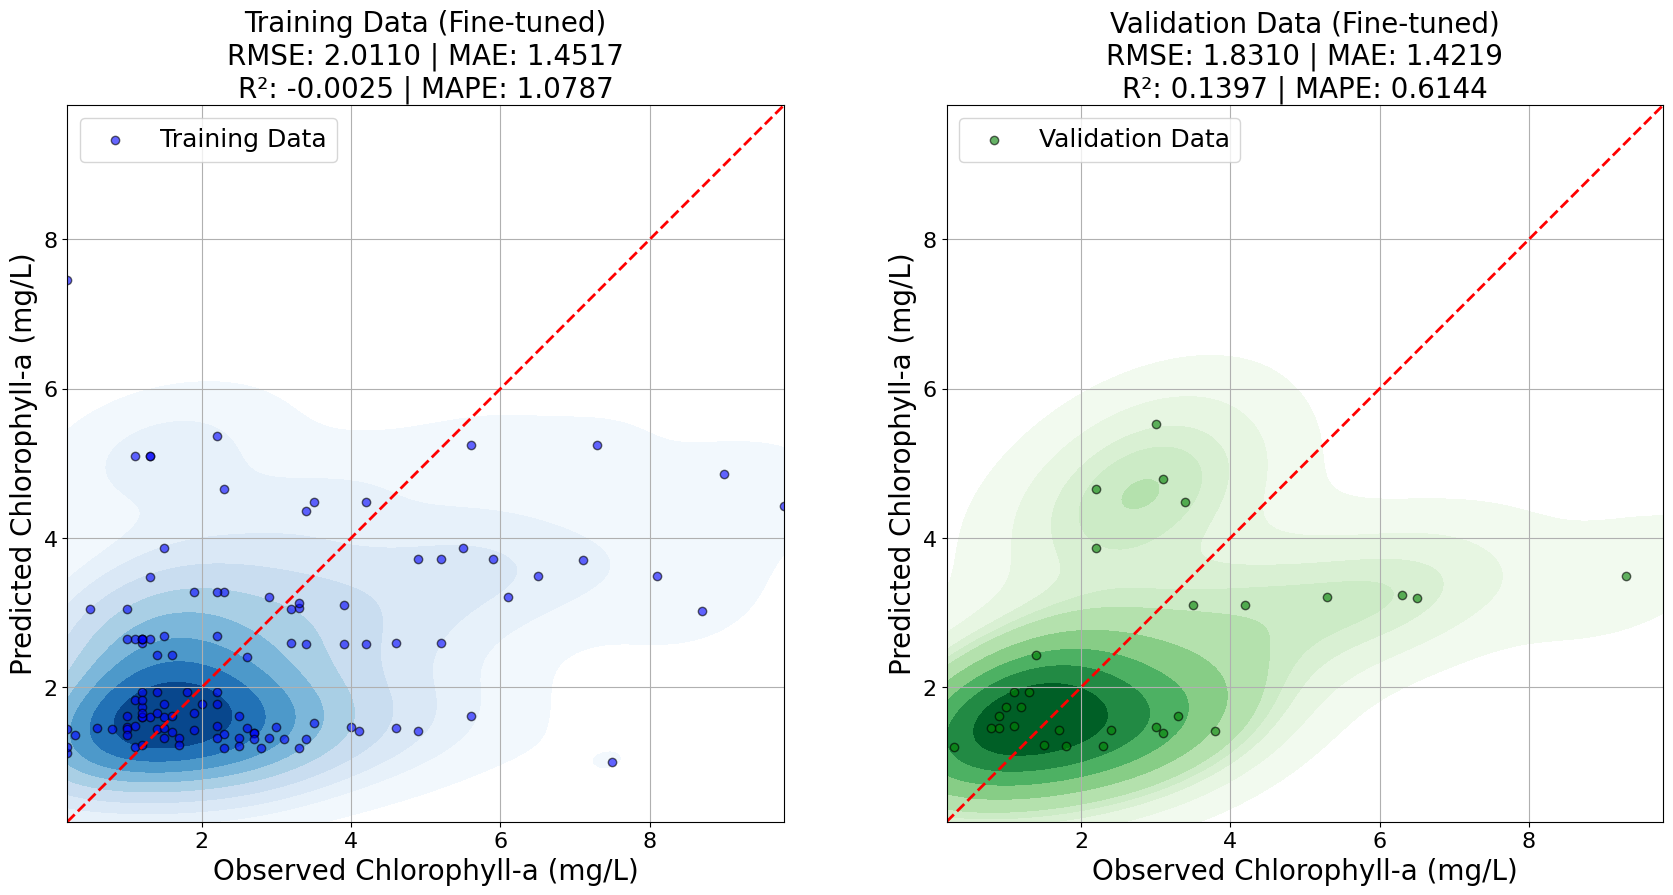

In [ ]:
# Load best parameters
best_lr = finetune_study.best_trial.params['lr']

# Load model
final_model = copy.deepcopy(surr_trained_model)
final_model.to(device)

# Fix to train last layer
for param in final_model.parameters():
    param.requires_grad = False

for param in final_model.model[-1].parameters():
    param.requires_grad = True


# Model setting
optimizer_name = best_params['optimizer']
weight_decay = best_params['weight_decay']
loss_function_name = best_params['loss_function']

# Loss function
if loss_function_name == "MSE":
    criterion = nn.MSELoss()
elif loss_function_name == "MAE":
    criterion = nn.L1Loss()
elif loss_function_name == "Huber":
    criterion = nn.SmoothL1Loss()

# Optimizer
trainable_params = filter(lambda p: p.requires_grad, final_model.parameters())
if optimizer_name == 'Adam':
    optimizer = optim.Adam(trainable_params, lr=best_lr, weight_decay=weight_decay)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(trainable_params, lr=best_lr, weight_decay=weight_decay)
elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(trainable_params, lr=best_lr, weight_decay=weight_decay)
elif optimizer_name == 'AdamW':
    optimizer = optim.AdamW(trainable_params, lr=best_lr, weight_decay=weight_decay)
elif optimizer_name == 'Adagrad':
    optimizer = optim.Adagrad(trainable_params, lr=best_lr, weight_decay=weight_decay)
else:
    raise ValueError(f"Unknown optimizer: {optimizer_name}")

# Model train
n_epochs_final = 100 # 최종 훈련을 위한 에포크 수
print("\n최종 모델 훈련 시작...")
for epoch in range(n_epochs_final):
    final_model.train()
    for batch_X, batch_y in train_loader: # 타겟 데이터로 훈련
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs_final}], Loss: {loss.item():.6f}")

print("최종 모델 훈련 완료!")


# Model evaluate
final_model.eval()
with torch.no_grad():
    train_predictions_tensor = final_model(X_train_tensor)
    test_predictions_tensor = final_model(X_test_tensor)

# Results
train_predictions = train_predictions_tensor.cpu().numpy().flatten()
test_predictions = test_predictions_tensor.cpu().numpy().flatten()
y_train = y_train_tensor.cpu().numpy().flatten()
y_test = y_test_tensor.cpu().numpy().flatten()

train_predictions_log = scaler_y.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
test_predictions_log = scaler_y.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_train_log = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_log = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

train_predictions_original = np.expm1(train_predictions_log)
test_predictions_original = np.expm1(test_predictions_log)
y_train_original = np.expm1(y_train_log)
y_test_original = np.expm1(y_test_log)

# Calculate evaluation metrics
training_rmse = np.sqrt(mean_squared_error(y_train_original, train_predictions_original))
validation_rmse = np.sqrt(mean_squared_error(y_test_original, test_predictions_original))
training_r2 = r2_score(y_train_original, train_predictions_original)
validation_r2 = r2_score(y_test_original, test_predictions_original)
training_mae = mean_absolute_error(y_train_original, train_predictions_original)
validation_mae = mean_absolute_error(y_test_original, test_predictions_original)
training_mape = mean_absolute_percentage_error(y_train_original, train_predictions_original)
validation_mape = mean_absolute_percentage_error(y_test_original, test_predictions_original)


# Visualization
plt.figure(figsize=(18, 9))
font_size = 20

# Determine the global min and max across both training and test sets for consistency
global_min = min(min(y_train_original), min(train_predictions_original), min(y_test_original), min(test_predictions_original))
global_max = max(max(y_train_original), max(train_predictions_original), max(y_test_original), max(test_predictions_original))

# Training Data Plot
plt.subplot(1, 2, 1)
sns.kdeplot(x=y_train_original, y=train_predictions_original, cmap="Blues", fill=True, bw_adjust=1)
plt.scatter(y_train_original, train_predictions_original, color='blue', edgecolor='k', alpha=0.6, label='Training Data')
plt.plot([global_min, global_max], [global_min, global_max], color='red', linestyle='--', linewidth=2)
plt.xlabel('Observed Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.ylabel('Predicted Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.title(
    f'Training Data (Fine-tuned)\n'
    f'RMSE: {training_rmse:.4f} | MAE: {training_mae:.4f}\n'
    f'R²: {training_r2:.4f} | MAPE: {training_mape:.4f}',
    fontsize=font_size
)
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(fontsize=font_size - 2)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=font_size - 4)

# Validation Data Plot
plt.subplot(1, 2, 2)
sns.kdeplot(x=y_test_original, y=test_predictions_original, cmap="Greens", fill=True, bw_adjust=1)
plt.scatter(y_test_original, test_predictions_original, color='green', edgecolor='k', alpha=0.6, label='Validation Data')
plt.plot([global_min, global_max], [global_min, global_max], color='red', linestyle='--', linewidth=2)
plt.xlabel('Observed Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.ylabel('Predicted Chlorophyll-a (mg/m³)', fontsize=font_size)
plt.title(
    f'Validation Data (Fine-tuned)\n'
    f'RMSE: {validation_rmse:.4f} | MAE: {validation_mae:.4f}\n'
    f'R²: {validation_r2:.4f} | MAPE: {validation_mape:.4f}',
    fontsize=font_size
)
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(fontsize=font_size - 2)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=font_size - 4)

plt.tight_layout(pad=3.0)
plt.show()